# Preprocessing: Feature Engineering


This notebook shows the steps to prepare raw gps data, building footprints data, administrative regions geospatial data, and road network data into files ready to be used in machine learning. These were all combined into a processed `pandas.DataFrame()` stored in `../datasets/processed/`.

The sections and the resulting features created by data from each section are as follows:
1. [Read GPS data files](#Read-GPS-data-files): `vehicle_id`, `dayofweek (0-7)`, `hour (0-23)`, `month (0-12)`, `instant_speed`, `datetime`, etc.
2. [Prepare road network data](#Prepare-Road-Network-info): `road_osmid`, `number_of_lanes`, `speed_limit_kph`, `road_segment_length`, `distance_to_road`
3. [Prepare barangay (administrative regions) info](#Prepare-Barangay-info): `barangay`
4. [Prepare land-use profile data](#Prepare-Land-use-profile-data): `pix_residential`, `pix_commercial`, `pix_institutional`, `pix_industrial`
5. [Feature engineering `multiprocessing` utils](#Feature-Engineering-Utils)
6. [Run preprocessing](#RUN)

# Read GPS data files

In [1]:
from time import time
start_time = time()

import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import re
import geopandas as gpd

from datetime import datetime

In [2]:
# source of raw data from stops-API of the GPS provider
# stops-API filters out data points with steady zero speed at time durations greater than 1 minute (c/o provider)
gps_data_files = glob('/mnt/processed/private/paturo/Geospatial/data/gps_cache/route_cleaned/*/*.csv')

# inspect filename info
print("Filename: ", gps_data_files[0])

# inspect contents
display(pd.read_csv(gps_data_files[0]).info())

Filename:  /mnt/processed/private/paturo/Geospatial/data/gps_cache/route_cleaned/20210426-000000/123200872603.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54169 entries, 0 to 54168
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        54169 non-null  object 
 1   altitude    54169 non-null  int64  
 2   angle       54169 non-null  int64  
 3   speed       54169 non-null  int64  
 4   accel       54169 non-null  int64  
 5   ai1         54169 non-null  int64  
 6   ai2         54169 non-null  int64  
 7   ai3         54169 non-null  int64  
 8   ai4         54169 non-null  int64  
 9   alarm_code  54169 non-null  int64  
 10  bats        54169 non-null  int64  
 11  decel       54169 non-null  int64  
 12  di1         54169 non-null  int64  
 13  di2         54169 non-null  int64  
 14  di3         54169 non-null  int64  
 15  di4         54169 non-null  int64  
 16  di5         54169 non-null  int64 

None

In [3]:
# helper function for imei extraction
def _extract_imei(str_):
    """Extracts imei from path str"""
    pattern = r"([\d]*)(?=\.csv)"
    match = re.search(pattern, str_)
    return match.group(0) # return imei

def id_tagger(path):
    """Adds a vehicle id column extracted from source file IMEI name"""
    df = pd.read_csv(path)
    df['vehicle_id'] = _extract_imei(path)
    return df

def col_rename(df, rename_mapper):
    """Renames the columns according to preference"""
    df = df.rename(columns=rename_mapper)
    return df

def nan_filter(df, usecols):
    """Filters rows according to important columns."""
    df = df.dropna(how='any', subset=usecols)
    return df

### Initial filtering from source [DONE]

In [4]:
# 6 min, done
save_root = '../datasets/raw/'
for path in tqdm(gps_data_files):
    df = id_tagger(path)
    df = col_rename(df, {'speed':'instant_speed',
                         'time': 'datetime'})
    df = nan_filter(df, ['lon', 'lat', 'instant_speed'])
    dir_ = "/".join(path.split('/')[-3:-1])
    save_dir = os.path.join(save_root, dir_)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, _extract_imei(path)+'.csv')
    df.to_csv(save_path, index=False)

100%|██████████| 660/660 [08:07<00:00,  1.35it/s]


### Read filtered data from local data repo

In [4]:
filtered_data_files = glob('../datasets/raw/route_cleaned/*/*.csv')
df = pd.concat([pd.read_csv(path) for path in filtered_data_files])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37162408 entries, 0 to 102636
Data columns (total 27 columns):
 #   Column         Dtype  
---  ------         -----  
 0   datetime       object 
 1   altitude       int64  
 2   angle          int64  
 3   instant_speed  int64  
 4   accel          float64
 5   ai1            int64  
 6   ai2            int64  
 7   ai3            int64  
 8   ai4            int64  
 9   alarm_code     int64  
 10  bats           int64  
 11  decel          float64
 12  di1            int64  
 13  di2            int64  
 14  di3            int64  
 15  di4            int64  
 16  di5            int64  
 17  do1            int64  
 18  do2            int64  
 19  do3            int64  
 20  do4            int64  
 21  gpslev         int64  
 22  hdop           float64
 23  odo            int64  
 24  lon            float64
 25  lat            float64
 26  vehicle_id     int64  
dtypes: float64(5), int64(21), object(1)
memory usage: 7.8+ GB


## Prepare Road Network info

### Adding more edge (road) data: `speed_kph`,  `lanes`, `distance_to_road`, `osmid`, `length`
This section appends additional road data on maximum speed of a road and its number of lanes. Also, some cleaning is performed in cases where there are more than one `osmid`s tagged for a road.

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import networkx as nx
import os
from glob import glob
from tqdm import tqdm

def _clean_maxspeed(value, convert_mph=True):
    try:
        return float(value)

    except ValueError:
        return None
    
def _collapse_multiple_maxspeed_values(value, agg):
    # if this isn't a list, just return it right back to the caller
    if not isinstance(value, list):
        return value

    else:
        try:
            # clean each value in list and convert to kph if it is mph then
            # return a single aggregated value
            values = [x for x in value]
            return int(agg(pd.Series(values).dropna().astype(int)))
        except ValueError:
            return None
        
def add_edge_lanes(G, hwy_lanes=None, fallback=None, precision=1, agg=np.median):

    if fallback is None:
        fallback = np.nan

    edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)

    # collapse any highway lists (can happen during graph simplification)
    # into string values simply by keeping just the first element of the list
    edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)

    if "lanes" in edges.columns:
        # collapse any maxspeed lists (can happen during graph simplification)
        # into a single value
        edges["lanes"] = edges["lanes"].apply(_collapse_multiple_maxspeed_values, agg=agg)
        
        # create speed_kph by cleaning maxspeed strings and converting mph to
        # kph if necessary
        edges["lanes"] = edges["lanes"].astype(str).map(_clean_maxspeed).astype(float)
    else:
        # if no edges in graph had a maxspeed attribute
        edges["lanes"] = None

    # if user provided hwy_lanes, use them as default values, otherwise
    # initialize an empty series to populate with values
    if hwy_lanes is None:
        hwy_lane_avg = pd.Series(dtype=float)
    else:
        hwy_lane_avg = pd.Series(hwy_lanes).dropna()

    # for each highway type that caller did not provide in hwy_lanes, impute
    # numlanes of type by taking the mode of the preexisting lane values of that
    # highway type
    for hwy, group in edges.groupby("highway"):
        if hwy not in hwy_lane_avg:
            hwy_lane_avg.loc[hwy] = agg(group["lanes"])

    # if any highway types had no preexisting lane values, impute their lane
    # with fallback value provided by caller. if fallback=np.nan, impute lane
    # as the mode lane of all highway types that did have preexisting values
    hwy_lane_avg = hwy_lane_avg.fillna(fallback).fillna(agg(hwy_lane_avg))

    # for each edge missing speed data, assign it the imputed value for its
    # highway type
    lanes = (
        edges[["highway", "lanes"]].set_index("highway").iloc[:, 0].fillna(hwy_lane_avg)
    )

    # all speeds will be null if edges had no preexisting maxspeed data and
    # caller did not pass in hwy_lanes or fallback arguments
    if pd.isnull(lanes).all():
        raise ValueError(
            (
                "this graph's edges have no preexisting `maxspeed` "
                "attribute values so you must pass `hwy_lanes` or "
                "`fallback` arguments."
            )
        )
    # add speed kph attribute to graph edges
    edges["lanes"] = lanes.round(precision).values
    
    # set values dict format as required by nx.set_edge_attributes()
#     values = edges.set_index(['u', 'v', 'key'])['lanes'].to_dict() # 9091
    values = edges['lanes'].to_dict() # 9092
    nx.set_edge_attributes(G, values=values, name="lanes")

    return G

In [6]:
path = '/mnt/processed/private/paturo/data/processed/graphs/cauayan.pickle'

with open(path, 'rb') as handle:
    G = pickle.load(handle)

hwy_speeds = {
    'trunk': 80, # most untagged values are near away from city center
    'primary': 40,
    'secondary': 30, # unpaved!!! dirt roads
    'tertiary': 30,
    'residential': 20,
    'unclassified': 20   
}

hwy_lanes = {
    'trunk': 2, # conservative guess
    'primary': 1,
    'secondary': 1,
    'tertiary': 1,
    'residential': 1,
    'unclassified': 1   
}

G = ox.speed.add_edge_speeds(G, hwy_speeds=hwy_speeds, fallback=None, precision=1)
G = add_edge_lanes(G, hwy_lanes=hwy_lanes, fallback=None, precision=1)

# inspect the road network data
nodes, edges = ox.graph_to_gdfs(G)
edges.head(2)

osmid  lanes                  name   highway  \
u          v          key                                                     
2420047872 2420047864 0    233655497    2.0  Golden Shower Avenue  tertiary   
           2420047871 0    233655497    2.0  Golden Shower Avenue  tertiary   

                          maxspeed  oneway   length  bearing  speed_kph  \
u          v          key                                                 
2420047872 2420047864 0         30   False    8.289  258.627       30.0   
           2420047871 0         30   False  200.558   88.395       30.0   

                                                                    geometry  \
u          v          key                                                      
2420047872 2420047864 0    LINESTRING (368870.013 1873786.707, 368861.867...   
           2420047871 0    LINESTRING (368870.013 1873786.707, 368879.602...   

                           ref width bridge service access junction  
u          v          key                                            
2420047872 2420047864 0    NaN   NaN    NaN     NaN    NaN      NaN  
           2420047871 0    NaN   NaN    NaN     NaN    NaN      NaN

### Projection: `G` to `P` and initialization of `edges_df`

In this section we take the same road network of Cauayan (`G`) from the previous preprocessing step of adding road speed data and project it to `P` having a CRS suitable for our vehicle gps coordinates format (EPSG:4326).

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from osmnx import projection

# put crs into road_network (previously no crs)
G.crs = "EPSG:32651"

# project to epsg:4326 to suit lon lat for use in RUN section
P = ox.projection.project_graph(G, to_crs="epsg:4326")

# used in tagging road data to vehicle
edges_df = ox.graph_to_gdfs(P, nodes=False) # 9092 use only this line
# edges_df = edges_df.set_index(['u', 'v', 'key']) # 9091

In [9]:
edges_df.info() # available road data

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 7365 entries, (2420047872, 2420047864, 0) to (7793950669, 7793950680, 0)
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      7365 non-null   object  
 1   lanes      6504 non-null   float64 
 2   name       1218 non-null   object  
 3   highway    7365 non-null   object  
 4   maxspeed   821 non-null    object  
 5   oneway     7365 non-null   bool    
 6   length     7365 non-null   float64 
 7   bearing    7355 non-null   float64 
 8   speed_kph  7365 non-null   float64 
 9   ref        398 non-null    object  
 10  width      352 non-null    object  
 11  bridge     52 non-null     object  
 12  access     14 non-null     object  
 13  service    34 non-null     object  
 14  junction   3 non-null      object  
 15  geometry   7365 non-null   geometry
dtypes: bool(1), float64(4), geometry(1), object(10)
memory usage: 1.1+ MB


## Prepare Barangay info

This section uses polygon data of barangays in Cauayan City to identify the barangay a vehicle is currently in. A new column `barangay` is created using the functions defined in the sections that follow.

In [10]:
root = '/mnt/processed/private/paturo/Geospatial/preprocessing'

admin_bounds_file = os.path.join(root, "admin.zip")
admin_df = gpd.read_file(admin_bounds_file)
admin_df.at[12, "Brgy_Name"] = "Carabatan Bacareno"

# used in tagging vehicle to a barangay
barangay_polygons = admin_df[['Brgy_Name', 'geometry']]
admin_df.head(2)

,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,Brgy_Name,Area,Population,Class,Region,Area_sqm,Density_sq,geometry
0,None,None,None,None,None,None,-1,0,-1,None,None,Alicaocao,51.57,1564,R,Poblacion,726433.0,2152.985891,"POLYGON Z ((121.77603 16.94689 0.00000, 121.77..."
1,None,None,None,None,None,None,-1,0,-1,None,None,Alinam,330.50,1167,R,Tanap,3026647.0,385.575193,"POLYGON Z ((121.75682 16.86332 0.00000, 121.75..."


In [11]:
admin_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Prepare Land-use profile data

This section shows the preparation steps for the land-use profile data added to the main dataset. Land use is divided according to 4 building types: residential, commercial, industrial, and institutional. These building appear as per pixel tagging in a `.tiff` file. Resolution depends on the `.tiff` file used--which can be either an 8x8- or 4x4-meter per pixel.

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import multiprocessing as mp
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

### Visualization of raster and city boundary

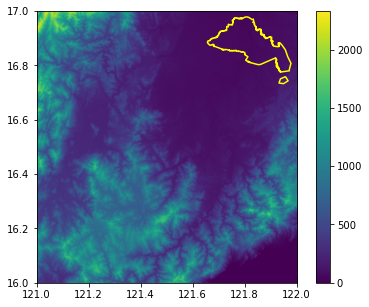

In [13]:
raster_root = '../datasets/raster-data/'
hgt_file = "N16E121.hgt"
src_path = os.path.join(raster_root, hgt_file)
src = rasterio.open(src_path, driver="SRTMHGT")

bounds_path = os.path.join(raster_root, 'bounds.pkl')
boundaries = pd.read_pickle(bounds_path)
                     
fig, ax = plt.subplots(figsize=(7,5))
show(src, ax=ax)
plt.colorbar(ax.images[0])
boundaries.boundary.plot(ax=ax, color='yellow')
plt.show()

In [14]:
def get_value(coords, src):
    """Return elevation from src"""
    
    if type(coords) != list:
        coords = [coords]
    return next(src.sample(coords))[0]

def get_building_counts(row, src, buffer, building_types):
    """Return pixel count of a building class within a buffer"""
    geometry = row.geometry.buffer(buffer) # buffer points by the meters (ensure data is projected)
    out_image, out_transform = mask(src, [geometry], all_touched=True, crop=True)
    for key, val in building_types.items():
        row[key] = np.sum(out_image==val)
    return row

## Feature Engineering Utils

In [15]:
from osmnx.distance import nearest_edges

def mp_tag_road_data(chunk, P, interpolate_dist, edges_df, road_cols):
    """Return df (chunk) with road network data corresponding to road_cols
    plus distance_to_road.
    """
    nearest_edge, distances = nearest_edges(
        P, 
        chunk['lon'], chunk['lat'],
        interpolate=interpolate_dist/6.371e6,
        return_dist=True,
    )
    road_data = edges_df.loc[nearest_edge, road_cols]
    chunk = pd.concat(
        [chunk.reset_index(drop=True), road_data.reset_index(drop=True)],
        axis=1
    )
    chunk['distance_to_road'] = distances
    return chunk

def mp_tag_brgy_data(chunk, barangay_polygons):
    """Return df (chunk) with new column: barangay, corresponding to brgy name"""
    temp = chunk[['lon', 'lat']]
    vehicle_coords = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.lon, temp.lat))
    vehicle_coords.crs = "epsg:4326"
    chunk['barangay'] = gpd.sjoin(
        vehicle_coords, barangay_polygons, 
        how='left', 
        op='within')['Brgy_Name']
    chunk['barangay'] = chunk['barangay'].fillna('Out-of-town')
    return chunk
    
def mp_create_datetime_cols(chunk, datetime_col):
    """Create hour, dayofweek, and month columns form datetime col."""
    # Adding datetime cat cols
    chunk['datetime'] = pd.to_datetime(chunk['datetime'])
    chunk['hour'] = chunk[datetime_col].dt.hour
    chunk['dayofweek'] = chunk[datetime_col].dt.dayofweek
    chunk['month'] = chunk[datetime_col].dt.month
    return chunk

def mp_elevation(gdf_chunk):
    """Calculate and add elevation data for chunk."""
    raster_root = '../datasets/raster-data/'
    hgt_file = "N16E121.hgt"
    src_path = os.path.join(raster_root, hgt_file)
    src = rasterio.open(src_path, driver="SRTMHGT")
    gdf_chunk['elevation'] = gdf_chunk.apply(lambda row: get_value((row.geometry.x, row.geometry.y), src), axis=1)
    return gdf_chunk

def mp_building_counts(gdf_chunk, tiff_file):
    """Calculate and add area of surrounding building type (in pixels)"""
    raster_root = '../datasets/raster-data/'
    tiff_tag = tiff_file.split('-')[-1].split('.')[0]
    
    building_types = {
        f'pix_business_{tiff_tag}': 1,
        f'pix_residential_{tiff_tag}': 2,
        f'pix_industrial_{tiff_tag}': 3,
        f'pix_institutional_{tiff_tag}': 4
    }
    
    footprints_path = os.path.join(raster_root, tiff_file)
    with rasterio.open(footprints_path) as src:
        gdf_chunk = gdf_chunk.to_crs(25393).apply(
            lambda x: get_building_counts(
                x, src, buffer=200, building_types=building_types), axis=1)
    return gdf_chunk

def parallelize_pandas(df, func, *args):
    cpus = mp.cpu_count()
    df_chunks = np.array_split(df, cpus)
    pool = mp.Pool(processes=cpus)
    chunk_processes = [pool.apply_async(func, args=(chunk,*args)) for chunk in df_chunks]
    df_results = []
    for chunk in chunk_processes:
        res = chunk.get()
        df_results.append(res)
    df_out = pd.concat(df_results)
    return df_out

def parallelize_geopandas(gdf, func, *args):
    """Parallelize functions used to get elevation and surrounding land-use area"""
    cpus = mp.cpu_count()
    gdf_chunks = np.array_split(gdf, cpus)
    pool = mp.Pool(processes=cpus)
    chunk_processes = [pool.apply_async(func, args=(chunk,*args)) for chunk in gdf_chunks]
    gdf_results = []
    for chunk in chunk_processes:
        res = chunk.get()
        res = res.to_crs(25393)
        gdf_results.append(res)
    gdf_out = gpd.GeoDataFrame(pd.concat(gdf_results))
    return gdf_out

## RUN

### Running per vehicle

In [16]:
def col_rename(df, rename_mapper):
    """Renames the columns according to preference"""
    df = df.rename(columns=rename_mapper)
    return df

rename_mapper = {
    'osmid': 'road_osmid',
    'lanes': 'number_of_lanes',
    'speed_kph': 'speed_limit_kph',
    'length': 'road_segment_length',
}

In [17]:
vehicle_grouper = df.groupby('vehicle_id')

In [20]:
# final run used.
date = '2022-05-27' # alternatively use now date for new runs

# date = str(datetime.date(datetime.now())) # now date
# print(date)

for index, (name, group) in enumerate(vehicle_grouper):
    
    # clause of resuming unfinished vehicle_ids
    save_dir = f'../datasets/processed/{date}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, str(name)) + '.csv'
    
    if not os.path.exists(save_path):
        print("Running for id: ", save_path)
        group = parallelize_pandas(group, mp_tag_road_data, P, 40, edges_df, ['osmid', 'lanes', 'speed_kph', 'length'])
        group = parallelize_pandas(group, mp_tag_brgy_data, barangay_polygons)
        group = group[group['barangay'] != 'Out-of-town']
        group = parallelize_pandas(group, mp_create_datetime_cols, 'datetime')
        
        gdf = gpd.GeoDataFrame(group, geometry=gpd.points_from_xy(group.lon, group.lat))
        gdf.crs = "epsg:4326"
        gdf = parallelize_geopandas(gdf, mp_elevation)
        gdf = parallelize_geopandas(gdf, mp_building_counts, f'footprints-4x4.tiff')

        group = pd.DataFrame(gdf.drop('geometry', axis=1))
        group = col_rename(group, rename_mapper)
        
        # save
        group.to_csv(save_path, index=False)
    print(f"Done: {index + 1}/200")

Done: 1/200
Done: 2/200
Done: 3/200
Done: 4/200
Done: 5/200
Done: 6/200
Done: 7/200
Done: 8/200
Done: 9/200
Done: 10/200
Done: 11/200
Done: 12/200
Done: 13/200
Done: 14/200
Done: 15/200
Done: 16/200
Done: 17/200
Done: 18/200
Done: 19/200
Done: 20/200
Done: 21/200
Done: 22/200
Done: 23/200
Done: 24/200
Done: 25/200
Done: 26/200
Done: 27/200
Done: 28/200
Done: 29/200
Done: 30/200
Done: 31/200
Done: 32/200
Done: 33/200
Done: 34/200
Done: 35/200
Done: 36/200
Done: 37/200
Done: 38/200
Done: 39/200
Done: 40/200
Done: 41/200
Done: 42/200
Done: 43/200
Done: 44/200
Done: 45/200
Done: 46/200
Done: 47/200
Done: 48/200
Done: 49/200
Done: 50/200
Done: 51/200
Done: 52/200
Done: 53/200
Done: 54/200
Done: 55/200
Done: 56/200
Done: 57/200
Done: 58/200
Done: 59/200
Done: 60/200
Done: 61/200
Done: 62/200
Done: 63/200
Done: 64/200
Done: 65/200
Done: 66/200
Done: 67/200
Done: 68/200
Done: 69/200
Done: 70/200
Done: 71/200
Done: 72/200
Done: 73/200
Done: 74/200
Done: 75/200
Done: 76/200
Done: 77/200
Done: 78

In [ ]:
end_time = time()

duration = end_time - start_time
print(f"PREPROCESSING TIME: {duration/3600} Hrs")

### One go [Kills Jojie Kernel]

This section runs the entire pre-processing pipeline using a `multiprocessing` approach on the full dataset. Consequently, writing to file is done per group according to a per-vehicle id grouping.

In [ ]:
# %%time
# # pandas
# processed_df = parallelize_pandas(df, mp_tag_road_data, P, 40, edges_df, ['osmid', 'lanes', 'speed_kph', 'length'])
# processed_df = parallelize_pandas(processed_df, mp_tag_brgy_data, barangay_polygons)
# processed_df = processed_df[processed_df['barangay'] != 'Out-of-town'] # filter out points outside cauayan city
# processed_df = parallelize_pandas(processed_df, mp_create_datetime_cols, 'time')

# # geopandas
# processed_gdf = gpd.GeoDataFrame(processed_df, geometry=gpd.points_from_xy(group.lon, group.lat))
# processed_gdf.crs = "epsg:4326"
# processed_gdf = parallelize_geopandas(processed_gdf, mp_elevation)
# processed_gdf = parallelize_geopandas(processed_gdf, mp_building_counts, 'footprints-4x4.tiff')

# processed_df = pd.DataFrame(processed_gdf.drop('geometry', axis=1))
# processed_df = col_rename(processed_df, rename_mapper)
# processed_df.info()

#### Save

In [ ]:
# vehicle_grouper = processed_df.groupby('vehicle_id')

# for name, group in vehicle_grouper:
#     save_dir = f'..datasets/processed/{date}'
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     group.to_csv(os.path.join(save_dir, str(name)) + '.csv', index=False)

In [ ]:
# end_time = time()

# duration = end_time - start_time
# print(f"PREPROCESSING TIME: {duration/3600} Hrs")

## End